<h1>First Assignment</h1>
<h2>Word embeddings</h2>
<h3>Intrinsic evaluation</h3>


● Objective:<br>
○ Prepare data for modeling language<br>
○ Learn a word2vec language model<br>
○ Evaluate the model<br>
Intrinsic evaluation<br>
<br>
● Code:<br>
○ gensym (there are other implementations)<br><br>

● Corpus:<br>
○ https://mattmahoney.net/dc/text8.zip (there are other corpora)<br><br>

● Pre-processing:<br>
○ Punctuation, lower case, etc.<br>
<br>

● Choices:<br>
○ training sizes, window sizes, CBOW vs Skip-Gram etc.<br><br>

● Evaluation:<br>
○ Analogies using https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt<br><br>

■ input three words, pick the returned word, compute the distance to the correct word<br>
■ Repeat and average<br>

--------------------------------------

Bibliotecas

In [21]:
#Bibliotecas
import os
import pandas as pd
import string
import itertools
import numpy as np

import nltk
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.test.utils import datapath

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

Pacotes

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Baixando os arquivos

In [3]:
!wget https://mattmahoney.net/dc/text8.zip

--2023-11-05 14:11:47--  https://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 34.198.1.81
Connecting to mattmahoney.net (mattmahoney.net)|34.198.1.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  77.4MB/s    in 0.4s    

2023-11-05 14:11:48 (77.4 MB/s) - ‘text8.zip’ saved [31344016/31344016]



In [4]:
!unzip text8.zip

Archive:  text8.zip
  inflating: text8                   


In [5]:
!wget https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt
# https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/datasets/questions-words.txt

--2023-11-05 14:11:49--  https://github.com/nicholas-leonard/word2vec/blob/master/questions-words.txt
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707045 (690K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 690.47K  --.-KB/s    in 0.08s   

2023-11-05 14:11:49 (8.97 MB/s) - ‘questions-words.txt’ saved [707045/707045]



--------------------------------------------------

In [6]:
# Define the file path to the text8 corpus
corpus_file = '/content/text8'
#corpus_file = '/content/text8_test' #Teste

<h2> Pré - Processamento </h2>


Optou-se por fazer uma lematização, nos termos para evitar que pequenas variações na palavra mudem drasticamente a contagem de termos. A baixo vemos um exemplo de palavras similares mas que foram contadas separadamente.<br><br>
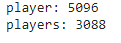

In [17]:
# Inicializa o lematizador
lemmatizer = WordNetLemmatizer()

# Funcao que tokeniza e preprocessa o texto
def preprocess_text(text):
    # Tokeniza dividindo nos espaços e transformando em minuscula
    tokens = [word.lower() for word in text.split()]

    # Remove pontuação
    tokens = [word.translate(str.maketrans('', '', string.punctuation)) for word in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematizatização
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

-------------------------------------------------------------

In [18]:
# Use LineSentence to read the corpus
sentences = LineSentence(corpus_file)

# Preprocess the sentences and create a list of tokenized sentences
preprocessed_sentences = [preprocess_text(" ".join(sentence)) for sentence in sentences]

print(preprocessed_sentences[:5])

[['anarchism', 'originated', 'term', 'abuse', 'first', 'used', 'early', 'working', 'class', 'radical', 'including', 'digger', 'english', 'revolution', 'sans', 'culotte', 'french', 'revolution', 'whilst', 'term', 'still', 'used', 'pejorative', 'way', 'describe', 'act', 'used', 'violent', 'mean', 'destroy', 'organization', 'society', 'also', 'taken', 'positive', 'label', 'self', 'defined', 'anarchist', 'word', 'anarchism', 'derived', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'political', 'philosophy', 'belief', 'ruler', 'unnecessary', 'abolished', 'although', 'differing', 'interpretation', 'mean', 'anarchism', 'also', 'refers', 'related', 'social', 'movement', 'advocate', 'elimination', 'authoritarian', 'institution', 'particularly', 'state', 'word', 'anarchy', 'anarchist', 'use', 'imply', 'chaos', 'nihilism', 'anomie', 'rather', 'harmonious', 'anti', 'authoritarian', 'society', 'place', 'regarded', 'authoritarian', 'political', 'structure', 'coercive', 'econo

Visualização contagem palavras

In [19]:
# Concatena os tokens em uma lista
tokens = [token for sentence in preprocessed_sentences for token in sentence]

# Contador de frequência
frequencia_tokens = Counter(tokens)

# Cria um DataFrame a partir do contador
df_1 = pd.DataFrame({'token': list(frequencia_tokens.keys()), 'frequencia': list(frequencia_tokens.values())})

# Cria o box plot usando o Plotly
fig = px.box(df_1, y='frequencia', hover_data=['token', 'frequencia'])

# Configura o layout do gráfico
fig.update_layout(
    title='Box Plot da Frequência de Tokens',
    xaxis_title='Tokens',
    yaxis_title='Frequência'
)

# Exibe o gráfico
fig.show()


-----------------------------------------------

<h2> Modelo </h2>

In [10]:
#Parametros que quero mexer:
#sg = 0  # Use CBOW (0 para CBOW, 1 para Skip-Gram)
sg_values = [0, 1]

# The default value of vector_size is 100.
vector_sizes = [100, 300]

#window sizes
window_sizes = [5, 10]

#min_count
min_counts = [2, 5, 11, 3000, 30000]
#min_counts = [2, 5] #teste

In [11]:
# Variáveis com partes do nome do arquivo
prefixo = "modelo"
extensao = ".model"

In [12]:
best_score = float("-inf")
best_model = None

data_list = []
count = 1
avg = 0

# Realize um loop através das combinações de parâmetros
for sg, vector_size, window_size, min_count in itertools.product(sg_values, vector_sizes, window_sizes, min_counts):
    # Crie e treine o modelo com os parâmetros atuais
    model = Word2Vec(sentences, sg=sg, vector_size=vector_size, window=window_size, min_count=min_count)

    # Crie o nome do arquivo com base nas variáveis
    nome_arquivo = f"{prefixo}_{sg}_{vector_size}_{window_size}_{min_count}{extensao}"
    print(nome_arquivo)

    # Save the trained model to a file
    model.save(nome_arquivo)

    # Avalia o modelo
    score = model.wv.evaluate_word_analogies(datapath('questions-words.txt'))

    # Atualize o melhor modelo se a pontuação atual for melhor
    if score[0] > best_score:
        best_score = score[0]
        best_model = model
    #Salva os dados como dicionarios
    modelo_data = data = {
    'Id': count,
    'Algoritmo': sg,
    'vector_size': vector_size,
    'window_size': window_size,
    'min_count': min_count,
    'score': score[0]
    }
    data_list.append(modelo_data)
    count = count + 1
    avg = avg + score[0]

modelo_0_100_5_2.model
modelo_0_100_5_5.model
modelo_0_100_5_11.model
modelo_0_100_5_3000.model
modelo_0_100_5_30000.model
modelo_0_100_10_2.model
modelo_0_100_10_5.model
modelo_0_100_10_11.model
modelo_0_100_10_3000.model
modelo_0_100_10_30000.model
modelo_0_300_5_2.model
modelo_0_300_5_5.model
modelo_0_300_5_11.model
modelo_0_300_5_3000.model
modelo_0_300_5_30000.model
modelo_0_300_10_2.model
modelo_0_300_10_5.model
modelo_0_300_10_11.model
modelo_0_300_10_3000.model
modelo_0_300_10_30000.model
modelo_1_100_5_2.model
modelo_1_100_5_5.model
modelo_1_100_5_11.model
modelo_1_100_5_3000.model
modelo_1_100_5_30000.model
modelo_1_100_10_2.model
modelo_1_100_10_5.model
modelo_1_100_10_11.model
modelo_1_100_10_3000.model
modelo_1_100_10_30000.model
modelo_1_300_5_2.model
modelo_1_300_5_5.model
modelo_1_300_5_11.model
modelo_1_300_5_3000.model
modelo_1_300_5_30000.model
modelo_1_300_10_2.model
modelo_1_300_10_5.model
modelo_1_300_10_11.model
modelo_1_300_10_3000.model
modelo_1_300_10_30000.mo

In [ ]:
# Melhor modelo com os melhores hiperparâmetros
best_sg = best_model.sg
best_vector_size = best_model.vector_size
best_window_size = best_model.window
best_min_count = 3000

# Variar o número de épocas
epochs_list = [10, 30, 50]

models_with_epochs = []

for num_epochs in epochs_list:
    # Crie e treine o modelo com o número de épocas variado
    model_with_epochs = Word2Vec(sentences, sg=best_sg, vector_size=best_vector_size, window=best_window_size, min_count=best_min_count, epochs=num_epochs)

    # Crie o nome do arquivo com base nas variáveis
    nome_arquivo = f"{prefixo}_{best_sg}_{best_vector_size}_{best_window_size}_{best_min_count}_{num_epochs}{extensao}"
    print(nome_arquivo)

    # Save the trained model to a file
    model.save(nome_arquivo)

    models_with_epochs.append(model_with_epochs)

# Crie uma lista de scores para os modelos variando as épocas
scores_with_epochs = []

for model_with_epochs in models_with_epochs:
    # Avalie o modelo
    score = model_with_epochs.wv.evaluate_word_analogies(datapath('questions-words.txt'))
    scores_with_epochs.append(score[0])


<h3> Melhor modelo </h3>

In [13]:
print(best_model)
print(f"Average score: {avg/count}")

Word2Vec<vocab=550, vector_size=100, alpha=0.025>
Average score: 0.3337082078863082


-----------------------------------------------

<h2>Tabela comparativa resultados</h2>

In [14]:
# @title Comparação alogritmos vários parâmetros
df = pd.DataFrame(data_list)

# Mapeia os valores da coluna 'Algoritmo' para 'CBOW' e 'Skipgram'
df['Algoritmo'] = df['Algoritmo'].map({0: 'CBOW', 1: 'Skipgram'})

# Classifica o DataFrame pela coluna 'score' em ordem decrescente
df = df.sort_values(by='score', ascending=False)

# Imprime o DataFrame
print(df)

    Id Algoritmo  vector_size  window_size  min_count     score
3    4      CBOW          100            5       3000  0.928571
8    9      CBOW          100           10       3000  0.928571
13  14      CBOW          300            5       3000  0.928571
23  24  Skipgram          100            5       3000  0.857143
38  39  Skipgram          300           10       3000  0.857143
18  19      CBOW          300           10       3000  0.857143
33  34  Skipgram          300            5       3000  0.857143
28  29  Skipgram          100           10       3000  0.785714
37  38  Skipgram          300           10         11  0.347307
27  28  Skipgram          100           10         11  0.342721
22  23  Skipgram          100            5         11  0.317401
17  18      CBOW          300           10         11  0.312169
32  33  Skipgram          300            5         11  0.312104
26  27  Skipgram          100           10          5  0.306053
36  37  Skipgram          300           

In [29]:
#@title Comparação best_model variando epochs

data_scores_with_epochs = {'Epochs': epochs_list, 'Scores': scores_with_epochs}

# Crie o DataFrame
df_epochs = pd.DataFrame(data_scores_with_epochs)

# Exiba o DataFrame
print(df_epochs)

   Epochs    Scores
0      10  0.928571
1      30  0.928571
2      50  0.928571


In [20]:
# Cria o box plot usando o Plotly
fig = px.box(df_1, y='frequencia', hover_data=['token', 'frequencia'])

# Configura o layout do gráfico
fig.update_layout(
    title='Box Plot da Frequência de Tokens',
    xaxis_title='Tokens',
    yaxis_title='Frequência'
)

# Adiciona linhas constantes
fig.add_shape(type='line', x0=0, x1=1, y0=2, y1=2, line=dict(color='red', width=2))
fig.add_shape(type='line', x0=0, x1=1, y0=5, y1=5, line=dict(color='green', width=2))
fig.add_shape(type='line', x0=0, x1=1, y0=11, y1=11, line=dict(color='blue', width=2))
fig.add_shape(type='line', x0=0, x1=1, y0=3000, y1=3000, line=dict(color='purple', width=2))
fig.add_shape(type='line', x0=0, x1=1, y0=30000, y1=30000, line=dict(color='orange', width=2))

# Exibe o gráfico
fig.show()

In [22]:
#tSNE - Função tirada de: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


In [ ]:
def plot_with_plotly(x_vals, y_vals, labels, plot_in_notebook=True):
    from plotly.offline import init_notebook_mode, iplot, plot
    import plotly.graph_objs as go

    trace = go.Scatter(x=x_vals, y=y_vals, mode='text', text=labels)
    data = [trace]

    if plot_in_notebook:
        init_notebook_mode(connected=True)
        iplot(data, filename='word-embedding-plot')
    else:
        plot(data, filename='word-embedding-plot.html')

In [26]:
x_vals, y_vals, labels = reduce_dimensions(best_model)

data = pd.DataFrame({'x': x_vals, 'y': y_vals, 'label': labels})

fig = px.scatter(data, x='x', y='y', text='label')

fig.update_traces(textposition='top right')
fig.show()